# Introduction

In this last notebook, we will create a full state feedback controller that will allow the human model to balance. There isn't time to give a good overview of controls, but we will use a very common optimal control method to quickly create a controller for our system.

# Setup

Bring in the results from the previous notebooks.

In [1]:
from __future__ import print_function
from solution.visualization import *

We will be working with numerical matrices so we will need several functions from NumPy.

In [2]:
from numpy import array, zeros, eye, asarray, dot, rad2deg
from numpy.linalg import inv

We will be simulating the model again with the controller in place and will make some plots of the state trajectories as before so bring in some useful functions from matplotlib. First enable inline plotting:

In [3]:
%matplotlib inline

In [4]:
from matplotlib.pyplot import plot, xlabel, ylabel, legend, rcParams

In [5]:
rcParams['figure.figsize'] = (14, 8)

Bring in some SymPy functions for simpilfication and printing:

In [6]:
from sympy import simplify, Matrix, matrix2numpy
from sympy.physics.vector import init_vprinting, vlatex

In [7]:
init_vprinting(use_latex='mathjax')

We will be displaying numerical matrices and the IPython magic `%precision` can be used to adjust how many decimal places are shown for nice compact printing.

In [8]:
%precision 3

'%.3f'

# Linearization

We current have symbolic equations of motion in this form:

$$ \mathbf{M}(\mathbf{x}) \dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u}, t) $$

where $\mathbf{M}$ is the mass matrix, $\mathbf{x}$ is the state vector made up of the generalized coordinates and speeds, and $\mathbf{f}(\mathbf{x}, \mathbf{u})$ is a vector of non-linear functions of the states, $\mathbf{x}$, and the specified inputs, $\mathbf{u}$.

This model is relatively easy to linearize and we will use a quick and dirty method to do so. In general, the non-linear equations of motion (for an unconstrained system) can be transformed into a linear form by expanding the Taylor series about small perturbations and truncating any non-linear terms. For this problem, this amounts to computing the [Jacobian](https://en.wikipedia.org/wiki/Jacobian) of the forcing vector, $\mathbf{f}$. The linear equations take this form:

$$ \mathbf{M} \Delta \dot{\mathbf{x}} = \mathbf{f}_A \Delta \mathbf{x} + \mathbf{f}_B \Delta \mathbf{u} $$

where $\mathbf{f}_A$ and $\mathbf{f}_B$ are the Jacobians of $\mathbf{f}$ with respect to the states and specified inputs, respectively:

$$ \mathbf{f}_A = \left[ \frac{\delta \mathbf{f} }{ \delta x_1}, \ldots, \frac{\delta \mathbf{f} }{ \delta x_n} \right] $$

$$ \mathbf{f}_B = \left[ \frac{\delta \mathbf{f} }{ \delta u_1}, \ldots, \frac{\delta \mathbf{f} }{ \delta u_n} \right] $$

and $\Delta \mathbf{x}$ and $\Delta \mathbf{u}$ are _differential_ changes in $\mathbf{x}$ and $\mathbf{u}$ respectively.

Once $\mathbf{f}_A$ and $\mathbf{f}_B$ are found, then the standard state space form of the linear equations can be formed by transforming the linear equations.

$$ \Delta \dot{x} = \mathbf{M}^{-1} \mathbf{f}_A \Delta \mathbf{x} + \mathbf{M}^{-1} \mathbf{f}_B \Delta \mathbf{u} $$

which can be rewritten as

$$ \Delta \dot{x} = \mathbf{A} \Delta \mathbf{x} + \mathbf{B} \Delta \mathbf{u} $$
   
where $\mathbf{A}$ is the state matrix and $\mathbf{B}$ is the input matrix.

The first step is to specify the equilbrium point about which to linearize. Our system has two unique equilibrium points, one when the person is upright, $\mathbf{x} = [0, \ldots, 0]$, and one when the person is upside down, $\mathbf{x} = [\pi, \ldots, \pi]$ (180 degrees). We are only concerned with the former because we want the model to "stand up".

In [9]:
equilibrium_point = zeros(len(coordinates + speeds))
equilibrium_point

array([ 0.,  0.,  0.,  0.,  0.,  0.])

We will use SymPy's `sub()` method to convert the linear equations of motion to numerical arrays, so we create two dictionaries containing the numerical values of the equilibrium point and the constants.

In [10]:
equilibrium_dict = dict(zip(coordinates + speeds, equilibrium_point))
equilibrium_dict

{ω₁: 0.0, ω₂: 0.0, ω₃: 0.0, θ₁: 0.0, θ₂: 0.0, θ₃: 0.0}

## Exercise

As an exercise, create a `parameter_dict` that maps the symbolic constants to the numerical constants. We have variable names for each already available from the previous notebooks (`constants` and `numerical_constants`).

In [12]:
# %load exercise_solutions/n09_control_parameter-dict.py
parameter_dict = dict(zip(constants, numerical_constants))
parameter_dict


{I_Lz: 0.101, I_Tz: 1.485, I_Uz: 0.282, d_L: 0.387, d_T: 0.305, d_U: 0.193, g:
 9.81, l_L: 0.611, l_U: 0.424, m_L: 6.769, m_T: 32.44, m_U: 17.01}

The `KanesMethod` object from earlier contains methods for linearizing the equations of motion. First, we'll create a `Linearizer` object:

In [13]:
linearizer = kane.to_linearizer()

This creates an object that holds a *generalized form* of the equations of motion, which can be used to linearize the system in a robust way. When it does this, it finds the inputs `r`, and orders them alphabetically. We have our own order we want to use from before, so we need to change this:

In [14]:
linearizer.r == Matrix(specified)

False

In [15]:
linearizer.r = Matrix(specified)

To perform the actual linearization, we'll use the `linearize` method:

In [16]:
help(linearizer.linearize)

Help on method linearize in module sympy.physics.mechanics.linearize:

linearize(op_point=None, A_and_B=False, simplify=False) method of sympy.physics.mechanics.linearize.Linearizer instance
    Linearize the system about the operating point. Note that
    q_op, u_op, qd_op, ud_op must satisfy the equations of motion.
    These may be either symbolic or numeric.
    
    Parameters
    ----------
    op_point : dict or iterable of dicts, optional
        Dictionary or iterable of dictionaries containing the operating
        point conditions. These will be substituted in to the linearized
        system before the linearization is complete. Leave blank if you
        want a completely symbolic form. Note that any reduction in
        symbols (whether substituted for numbers or expressions with a
        common parameter) will result in faster runtime.
    
    A_and_B : bool, optional
        If A_and_B=False (default), (M, A, B) is returned for forming
        [M]*[q, u]^T = [A]*[q_in

Because we want to get the equations in the form

$$ \Delta \dot{x} = \mathbf{A} \Delta \mathbf{x} + \mathbf{B} \Delta \mathbf{u} $$

we'll set `A_and_B=True`. We can also perform the variable to numeric substitution in this step by passing in both the `equilibrium_dict` and the `parameter_dict` to the operating point.

In [17]:
A, B = linearizer.linearize(op_point=[equilibrium_dict, parameter_dict], A_and_B=True)

Now we can convert from symbolic to numeric numpy matrices, and display our results:

In [18]:
A = matrix2numpy(A, dtype=float)
B = matrix2numpy(B, dtype=float)

In [19]:
A

array([[   0.   ,    0.   ,    0.   ,    1.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   ,    0.   ,    1.   ,    0.   ],
       [   0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    1.   ],
       [  18.337,  -75.864,    6.395,    0.   ,    0.   ,    0.   ],
       [ -22.175,  230.549,  -49.01 ,    0.   ,    0.   ,    0.   ],
       [   4.353, -175.393,   95.29 ,    0.   ,    0.   ,    0.   ]])

In [20]:
B

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.292, -0.785,  0.558],
       [-0.785,  2.457, -2.178],
       [ 0.558, -2.178,  2.601]])

# Controller Design

Before we try to create a controller, we need to check to see if it is actually [controllable](https://en.wikipedia.org/wiki/Controlability). You can import a function from the `utils` module included with these notebooks to check.

In [21]:
from utils import controllable

In [22]:
controllable(A, B)

True

So yes, the system is controllable. Now we will use [optimal control theory](https://en.wikipedia.org/wiki/Optimal_control) to create a controller that compute the necessary joint torques at each time step to balance the person.

It turns out that if you setup a cost function in which you'd like to minimize the deviation from the desired state, 0, and minimize the effort in the joint torques, there is an elegant solution to find a matrix $\mathbf{K}$ which can be used to compute the joint torques given the current state value.

Given the cost function:

$$J = \frac{1}{2} \int_0^\infty\left[\mathbf{x}^T \mathbf{Q} \mathbf{x} + \mathbf{u}^T \mathbf{R} \mathbf{u}\right]dt$$

There is a matrix $\mathbf{K}$ that computes the inputs $\mathbf{u}(t)$ given the states $\mathbf{x}$:

$$\mathbf{u}(t) = -\mathbf{K} \mathbf{x}(t)$$

where $\mathbf{K}$ can be found by the solution to the algebraic [Riccati Equation](https://en.wikipedia.org/wiki/Riccati_equation) such that:

$$\mathbf{K} = \mathbf{R}^{-1} \mathbf{B}^T \mathbf{S}$$

and the Riccati equation is:

$$\textbf{0} = -\textbf{S}\textbf{A}-\textbf{A}^{\text{T}}\textbf{S}+\textbf{S}\textbf{B}\textbf{R}^{-1}\textbf{B}^{\text{T}}\textbf{S}-\textbf{Q}$$

SciPy provides a function that can compute the solution, $\mathbf{S}$, of the continous algebraic Riccati Equation.

In [23]:
from scipy.linalg import solve_continuous_are

The weighting matrices, $\mathbf{Q}$ and $\mathbf{R}$, allow you to control how much weight is applied to minimizing the error in the states and the effort in the inputs. A typical starting point for these matrices is to set them equal to the identity matrix, which can be created with the NumPy `eye()` function.

In [24]:
Q = eye(6)
Q

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [25]:
R = eye(3)
R

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

$\mathbf{K}$ can now be computed.

In [26]:
S = solve_continuous_are(A, B, Q, R)
K = dot(dot(inv(R), B.T),  S)
K

array([[ 1054.367,   426.901,   153.864,   365.784,   173.577,    67.28 ],
       [  707.669,   610.181,   251.283,   263.836,   158.583,    72.18 ],
       [   12.129,    43.669,   132.469,    11.613,    16.447,    19.12 ]])

Remember that the `right_hand_side` function we generated earlier can take a function for the specified values.

In [27]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(6,)
        The state vector is ordered as such:
            - theta1(t)
            - theta2(t)
            - theta3(t)
            - omega1(t)
            - omega2(t)
            - omega3(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(3,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 3. If the value is a
 

## Exercise

Create a function named `controller` that computes the specified inputs given the current state and time.

In [28]:
def controller():
    """Returns the output of the controller, i.e. the joint torques, given the current state."""
    return

In [30]:
# %load exercise_solutions/n09_control_controller-function.py
def controller(x, t):
    """Returns the output of the controller, i.e. the joint torques, given
    the current state."""
    return -dot(K, x)


Now we can integrate the equations of motion again, but this time with the controller in place.

## Exercise

Integrate the equations of motion and plot the coordinates and speeds as we did in the simulation notebook and see if the system behaves as expected.

In [32]:
# %load exercise_solutions/n09_control_integrate-eom.py
y = odeint(right_hand_side, x0, t, args=(controller, numerical_constants))


# Plot Trajectories

## Exercise

Use the same plot functions as were used in the simulation notebook to inspect the state trajectories.

In [33]:
# Plot the angles



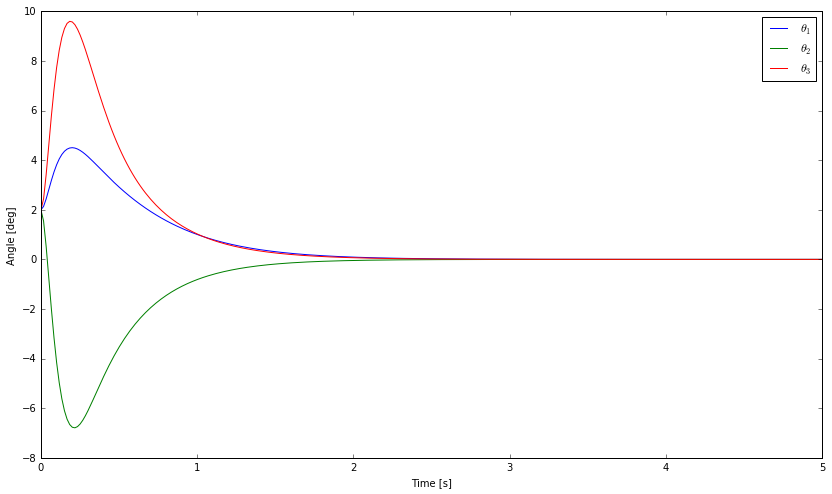

In [35]:
# %load exercise_solutions/n09_control_plot-angles.py
plot(t, rad2deg(y[:, :3]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

In [36]:
# Plot the angular velocities



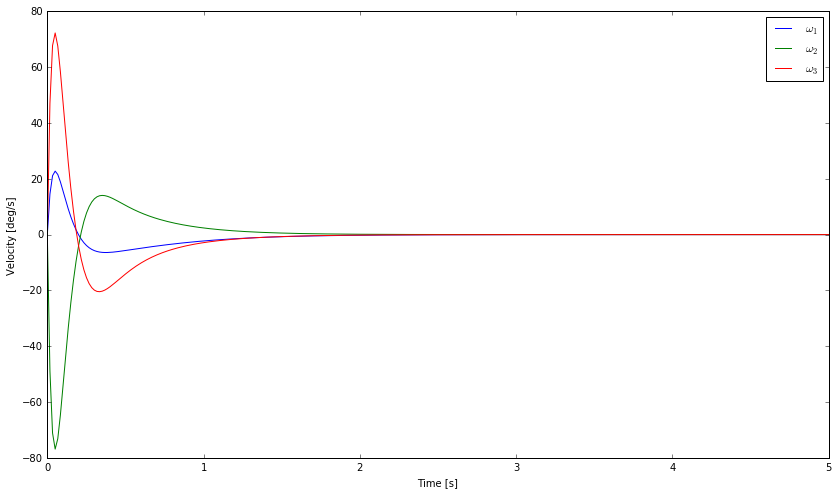

In [38]:
# %load exercise_solutions/n09_control_plot-velocities.py
plot(t, rad2deg(y[:, 3:]))
xlabel('Time [s]')
ylabel('Velocity [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])


What do these plots tell you about the controller? Does it work?

# Visualization

Finally, regenerate the visualization to see the 3D animation of the system under the influence of the controller.

In [39]:
scene.states_trajectories = y

In [40]:
scene.display_ipython()